In [28]:
import ee
import geemap

In [29]:
Map = geemap.Map()

In [30]:
ee.Initialize()

In [31]:
from utils.utils import correct_image_shape, milsec2date, read_csv
from utils.ee_utils import *

In [58]:
# roi = get_square_roi(52.37962731,7.164954376, roi_size=1920, return_gee_object=True)
roi = get_square_roi(53.10515397,13.30088236, roi_size=1920, return_gee_object=True)
Map = geemap.Map(zoom=12)
Map.addLayer(roi)
Map.centerObject(roi)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [59]:
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                .filterDate('2015-01-01', '2015-12-31') \
                .filter(ee.Filter.lt('CLOUD_COVER',10)) \
                .filterBounds(roi) \
                #.filter(ee.Filter.contains('.geo', roi)) #this line checks if the scene completly covers the roi, which mean roi is in the scene
print(l8.size().getInfo())
print('Date:',milsec2date(l8.aggregate_array('system:time_start').getInfo()))

7
Date: ['2015-04-10', '2015-10-03', '2015-03-25', '2015-09-01', '2015-10-03', '2015-06-04', '2015-10-10']


In [60]:
l8_img = l8.median().clip(roi).multiply(2.75e-05).add(-0.2)
bands = ['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
l8_img = l8_img.select(bands)

In [61]:
geemap.download_ee_image(l8_img, "l8.tif",crs='EPSG:3857', scale=30,region = roi)

l8.tif: |          | 0.00/629k (raw) [  0.0%] in 00:00 (eta:     ?)

In [62]:
from skimage import io
import numpy as np
l8_np = io.imread('l8.tif')
print(l8_np.shape)
l8_np = correct_image_shape(l8_np)
print(l8_np.shape)
print(np.min(l8_np),np.max(l8_np))

(7, 106, 106)
(106, 106, 7)
-0.0011612500000000026 0.52133875


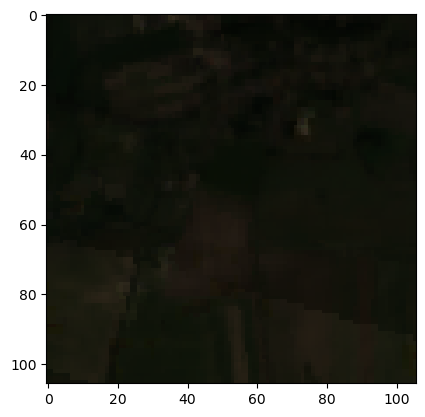

In [63]:
import matplotlib.pyplot as plt
plt.imshow(l8_np[:,:,[3,2,1]])

In [64]:
df = read_csv("LUCAS_2015_Germany.csv")
df

,Piont_id,long,lat
0,40463116,6.072879,51.088722
1,40463188,6.016994,51.734784
2,40523090,6.177697,50.858239
3,40523108,6.164374,51.019789
4,40543118,6.185448,51.110477
...,...,...,...
1681,46543152,14.786924,51.380586
1682,46563124,14.789346,51.128352
1683,46603108,14.831361,50.982524
1684,46623118,14.869216,51.070995


In [65]:
for index, row in df.iterrows():
    print(f'Point {index}' , end=" -> ")
    loop_roi = get_square_roi(row['lat'],row['long'], roi_size=1920, return_gee_object=True)
    l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                .filterDate('2015-01-01', '2015-12-31') \
                .filter(ee.Filter.lt('CLOUD_COVER',10)) \
                .filterBounds(loop_roi).sort('system:time_start')
                #.filter(ee.Filter.contains('.geo', loop_roi)) #this line checks if the scene completly covers the roi, which mean roi is in the scene
    #print(l8.size().getInfo())
    print('Date:',milsec2date(l8.aggregate_array('system:time_start').getInfo()))
    
    if index == 3:
        break

Point 0 -> Date: ['2015-01-07', '2015-03-12', '2015-07-11', '2015-08-03', '2015-09-29', '2015-09-29', '2015-12-09']
Point 1 -> Date: ['2015-01-07', '2015-03-12', '2015-08-03', '2015-09-29', '2015-12-09']
Point 2 -> Date: ['2015-07-11', '2015-09-29', '2015-09-29']
Point 3 -> Date: ['2015-01-07', '2015-03-12', '2015-07-11', '2015-08-03', '2015-09-29', '2015-09-29', '2015-12-09']


In [66]:
l8_c = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                .filterDate('2015-01-01', '2015-12-31') \
                .filter(ee.Filter.gt('CLOUD_COVER',20)) \
                .filter(ee.Filter.lt('CLOUD_COVER',60)) \
                .filterBounds(roi).sort('CLOUD_COVER', True)
                #.filter(ee.Filter.contains('.geo', roi)) #this line checks if the scene completly covers the roi, which mean roi is in the scene
print(l8_c.size().getInfo())
print('Date:',milsec2date(l8_c.aggregate_array('system:time_start').getInfo()))

17
Date: ['2015-06-29', '2015-10-26', '2015-12-06', '2015-08-07', '2015-09-17', '2015-05-03', '2015-09-17', '2015-07-06', '2015-02-05', '2015-09-01', '2015-08-16', '2015-06-13', '2015-03-09', '2015-05-19', '2015-02-21', '2015-07-15', '2015-11-27']


In [67]:
Map = geemap.Map()

l8_c_img = l8_c.first()
qa = l8_c_img.select('QA_PIXEL')
rgb = l8_c_img.select('SR_B4','SR_B3','SR_B2').multiply(2.75e-05).add(-0.2)
#cloud = qa.bitwiseAnd(1<<2).And(qa.bitwiseAnd(1<<6)).Or(qa.bitwiseAnd(1<<7))

# Define the cloud, cloud shadow, and snow/ice bits.
cloud = get_cloud_mask(l8_c_img)[0]
print(cloud.bandNames().getInfo())
cloudShadow = get_cloud_mask(l8_c_img)[1]

mask = cloud.where(cloud, 1)
mask = mask.where(cloudShadow, 2)

#Display the cloud mask on the map
Map.addLayer(mask, {'min': 0, 'max': 1, 'palette': ['000000', 'red', 'blue']}, 'Mask')

visualization = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
  'min': 0.0,
  'max': 0.3,
}

maskedImage = rgb.updateMask(cloud.Not())
Map.addLayer(maskedImage.clip(roi), visualization, 'masked')
Map.centerObject(roi)
Map

['QA_PIXEL']


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [68]:
masked_cliped = cloud.clip(roi)

# Compute the number of ones and total number of pixels in the mask
stats = masked_cliped.reduceRegion(
    reducer=ee.Reducer.sum().combine(
        reducer2=ee.Reducer.count(),
        sharedInputs=True
    ),
    geometry=masked_cliped.geometry(),
    scale=30,
    maxPixels=1e9
)

print(stats.keys().getInfo())
# Extract the number of ones and total number of pixels from the result
ones = stats.get('QA_PIXEL_sum')
total = stats.get('QA_PIXEL_count')

# Compute the ratio of ones to total pixels
ratio = ee.Number(ones).divide(total)

# Print the ratio to the console
print('Ratio of ones to total pixels:', ratio.getInfo())


['QA_PIXEL_count', 'QA_PIXEL_sum']
Ratio of ones to total pixels: 0.05371925070194308


In [69]:
print(get_mask_ones_ratio(masked_cliped).getInfo())

0.05371925070194308


In [70]:
l8_c = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                .filterDate('2015-01-01', '2015-12-31') \
                .filter(ee.Filter.gt('CLOUD_COVER',20)) \
                .filter(ee.Filter.lt('CLOUD_COVER',60)) \
                .filterBounds(roi).sort('CLOUD_COVER', True)
                #.filter(ee.Filter.contains('.geo', roi)) #this line checks if the scene completly covers the roi, which mean roi is in the scene
print(l8_c.size().getInfo())
lc8_cliped = l8_c.map(lambda img: img.clip(roi))
# lc8_cloud_masks = lc8_cliped.map(lambda img: get_cloud_mask(img)[0])
# print(lc8_cloud_masks.first().bandNames().getInfo())
lc8_cliped_w_ratio = lc8_cliped.map(lambda img: img.set('roi_cloud_ratio', get_mask_ones_ratio(get_cloud_mask(img)[0])))
print(lc8_cliped_w_ratio.size().getInfo())


17
17


In [71]:
lc8_cliped_w_ratio.first().getInfo()['properties']

{'roi_cloud_ratio': 0.05371925070194308,
 'system:footprint': {'type': 'Polygon',
  'coordinates': [[[12.776946558894407, 52.60583512789748],
    [12.805215731823385, 52.60583512789748],
    [12.805215731823386, 52.62310963131346],
    [12.776946558894409, 52.62310963131346],
    [12.776946558894407, 52.60583512789748]]]},
 'DATA_SOURCE_ELEVATION': 'GLS2000',
 'WRS_TYPE': 2,
 'REFLECTANCE_ADD_BAND_1': -0.2,
 'REFLECTANCE_ADD_BAND_2': -0.2,
 'DATUM': 'WGS84',
 'REFLECTANCE_ADD_BAND_3': -0.2,
 'REFLECTANCE_ADD_BAND_4': -0.2,
 'REFLECTANCE_ADD_BAND_5': -0.2,
 'REFLECTANCE_ADD_BAND_6': -0.2,
 'REFLECTANCE_ADD_BAND_7': -0.2,
 'REFLECTIVE_SAMPLES': 8051,
 'GROUND_CONTROL_POINTS_VERSION': 5,
 'SUN_AZIMUTH': 150.25124739,
 'DATA_SOURCE_TIRS_STRAY_LIGHT_CORRECTION': 'TIRS',
 'UTM_ZONE': 33,
 'DATE_ACQUIRED': '2015-06-29',
 'ELLIPSOID': 'WGS84',
 'system:time_end': 1435572116023,
 'DATA_SOURCE_PRESSURE': 'Calculated',
 'LANDSAT_PRODUCT_ID': 'LC08_L2SP_193023_20150629_20200909_02_T1',
 'STATION_I

In [72]:
lc8_cliped_w_ratio.aggregate_array('roi_cloud_ratio').getInfo()

[0.05371925070194308,
 0.8661333035469112,
 0.14321737297069365,
 0.8212116557992768,
 0,
 0.1265317900243411,
 0,
 0.14024564489930796,
 0,
 0.30371808661721617,
 0.9698194737405765,
 0.49162091813690584,
 0.8149353358364625,
 0,
 0.970895088028087,
 0.40031383724232944,
 0.8803283953030537]

In [73]:
# picking images where `roi_cloud_ratio` is less than 0.1
lc8_cliped_w_ratio_filtered=lc8_cliped_w_ratio.filter(ee.Filter.lt('roi_cloud_ratio',0.1)) 

In [74]:
lc8_cliped_w_ratio_filtered.aggregate_array('roi_cloud_ratio').getInfo()

[0.05371925070194308, 0, 0, 0, 0]

In [75]:
from typing import List
def get_mean_ndvi(image, bands: List[str] = ['SR_B5', 'SR_B4']):
    """
    Returns the mean NDVI of the given image.
    """
    # Compute NDVI
    ndvi = image.normalizedDifference(bands)
    
    # Compute mean of NDVI
    mean_ndvi = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=image.geometry(),
        scale=image.projection().nominalScale(),
        maxPixels=1e13
    ).get('nd')
    
    return mean_ndvi

In [76]:
print(lc8_cliped_w_ratio_filtered.size().getInfo())
lc8_cliped = lc8_cliped_w_ratio_filtered.map(lambda img: img.clip(roi))
lc8_cliped_w_mean_ndvi = lc8_cliped.map(lambda img: img.set('roi_mean_ndvi', get_mean_ndvi(img)))
print(lc8_cliped_w_mean_ndvi.size().getInfo())

5
5


In [77]:
lc8_cliped_w_mean_ndvi.aggregate_array('roi_mean_ndvi').getInfo()

[0.30064084727372414,
 0.23953914383505753,
 0.12796924562306547,
 0.18674043965551856,
 0.4198177989192243]

In [78]:
Map = geemap.Map()
# sort lc8_cliped_w_mean_ndvi based on roi_mean_ndvi
lc8_cliped_w_mean_ndvi_sorted_ascending = lc8_cliped_w_mean_ndvi.sort('roi_mean_ndvi', False)
print(lc8_cliped_w_mean_ndvi_sorted_ascending.first().getInfo()['properties']['roi_mean_ndvi'])
lc8_cliped_w_mean_ndvi_sorted_descending = lc8_cliped_w_mean_ndvi.sort('roi_mean_ndvi', True)
print(lc8_cliped_w_mean_ndvi_sorted_descending.first().getInfo()['properties']['roi_mean_ndvi'])
visualization = {
  'bands': ['SR_B4', 'SR_B3', 'SR_B2'],

}
Map.addLayer(lc8_cliped_w_mean_ndvi_sorted_ascending.first(), visualization, 'highest mean NDVI')

Map.addLayer(lc8_cliped_w_mean_ndvi_sorted_descending.first(), visualization, 'image with lowest mean NDVI')


Map.centerObject(roi)
Map

0.4198177989192243
0.12796924562306547


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [86]:
lc8_cliped_w_mean_ndvi_sorted_descending.aggregate_array('roi_mean_ndvi').getInfo()

[0.12796924562306547,
 0.18674043965551856,
 0.23953914383505753,
 0.30064084727372414,
 0.4198177989192243]

In [101]:
def get_null_pixel_ratio(image,roi):
    """
    Returns the ratio of null pixels to all of the pixels in an ee.Image.

    Parameters:
    -----------
    image : ee.Image
        The image to compute the ratio for.

    Returns:
    --------
    null_ratio : float
        The ratio of null pixels to all of the pixels in the image.

    """
    # Count the number of null pixels in the image
    mask = image.mask().clip(roi)
    null_pixels = mask.reduceRegion(reducer=ee.Reducer.sum(), geometry=roi, scale=image.projection().nominalScale()).values().get(0)
    
    # Count the total number of pixels in the image
    total_pixels = image.select(0).reduceRegion(reducer=ee.Reducer.count(), geometry=roi, scale=image.projection().nominalScale()).values().get(0)
    
    # Compute the ratio of null pixels to all of the pixels
    null_ratio = ee.Number(null_pixels).divide(total_pixels)
    
    return null_ratio.getInfo()

In [103]:
def is_col_empty(im_collection):
  '''if collection is empty returns `True`, if has vlues returns `False`'''
  dates = im_collection.aggregate_array('system:time_start').getInfo()
  if dates:
    return False
  else:
    return True

In [104]:
def dict_to_int(dic):
  pix_num = list(dic.items())[0][1] 
  return pix_num

In [115]:
def mosaic_covers_roi(imgecollection, roi, ref_band_name = 0,acceptance_rate = 0.95,scale = 100 , optimum_pix_num = 10000):
  '''
  the input is an image collection that has beed filterd by date and boundry

  Returns
  ---
  *  `True`  if the ratio of image to whole area is bigger that acceptance rate
  *  `False` the collection is empy or the ratio of image to whole area is smaller that acceptance rate
  '''
  if is_col_empty(imgecollection): # first we check if collection is not empty
    print('Collection was empty!')
    return False


  img = imgecollection.first().clip(roi).select(ref_band_name) # convertin image to mosaic and clip it by roi
  mask = img.mask().clip(roi) # create the mask and clip it by roi - clip is important beucase mask convers the whole globe

  img_pix_dict = img.reduceRegion(reducer=ee.Reducer.count(),geometry= roi,scale=scale).getInfo() # counting pixels
  msk_pix_dict = mask.reduceRegion(reducer=ee.Reducer.count(),geometry= roi,scale=scale).getInfo()

  img_pix_int = dict_to_int(img_pix_dict) # count() output is a dict , we need numbers 
  msk_pix_int = dict_to_int(msk_pix_dict)

 # if we chose the scale too high it the reuslat woudlnt be acurate, so we worte this functino as a 
 # recursive function, so it comes back and devides sacle by a factor of 10 and tries again
  if msk_pix_int <= optimum_pix_num:
    print('WARNING: low pixel nubmer - recurse activated - scale droped to ',round(scale/10))
    return mosaic_covers_roi(imgecollection, roi, ref_band_name, acceptance_rate,scale = round(scale/10))  # the return is crosial for a recursive func, i missed it the first time
  else:
    print(f'Mosiac Covers {(img_pix_int/msk_pix_int) * 100} percent of the roi',' - detail: ',f'Image Pixels = {img_pix_int} / All Pixels = {msk_pix_int}')
    #print(f'Image Pixels = {img_pix_int} / All Pixels = {msk_pix_int}')
    if img_pix_int >= acceptance_rate * msk_pix_int: 
      print('Mosaic Coverege Accepted')
      return True
    else:
      print('Mosaic Coverege Not Accepted')
      return False

In [116]:
mosaic_covers_roi(lc8_cliped_w_mean_ndvi_sorted_descending,roi)

Mosiac Covers 28.892512569642616 percent of the roi  - detail:  Image Pixels = 10631 / All Pixels = 36795
Mosaic Coverege Not Accepted


False

In [100]:
lc8_cliped_w_mean_ndvi_sorted_descending.map(lambda img: img.set('null_pixel_ratio', get_null_pixel_ratio(img,roi)))

EEException: A mapped function's arguments cannot be used in client-side operations